In [1]:
import requests
import pandas as pd
import numpy as np

In [3]:
web_url = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M').text
from bs4 import BeautifulSoup
soup = BeautifulSoup(web_url, 'lxml')
My_table = soup.find('table', {'class':'wikitable sortable'})
titles= []
for title in My_table.findAll('th'):
    titles.append(title.text)
print(titles)
rLength = len(My_table.findAll('tr'))
df = pd.DataFrame(index = np.arange(0, rLength+1,1), columns = list(titles))
rMarker = 0
for row in My_table.findAll('tr'):
    cMarker = 0
    columns = row.findAll('td')
    for column in columns:
        df.iat[rMarker, cMarker] = column.get_text()
        cMarker = cMarker + 1
    rMarker = rMarker + 1
df.head()
df.loc[(df['Borough'] != 'Not assigned') & (df['Neighbourhood\n'] == 'Not assgined')]
df.dropna(axis = 0, inplace = True)
df = df[df.Borough != 'Not assigned']
df = df.replace('\n', '', regex = True)
df.rename(columns = {'Neighbourhood\n':'Neighborhood'}, inplace = True)
df2 = df.groupby(['Postcode','Borough'])['Neighborhood'].apply(', '.join).reset_index()
postCodes = df2.Postcode.values

['Postcode', 'Borough', 'Neighbourhood\n']


In [22]:
lat_long = pd.read_csv('Geospatial_Coordinates.csv')
result = pd.concat([df2, lat_long], axis = 1, join = 'inner')
#result.drop('Postal Code', axis = 1, inplace = True)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import json
from pandas.io.json import json_normalize
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
from geopy.geocoders import Nominatim
import folium
address = 'Toronto, Canada'
geolocator = Nominatim(user_agent = 'Toronto_explorer')
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
TorontoDf = result.query('Borough.str.contains("Toronto")', engine = 'python')
resultSave = result

In [23]:
CLIENT_ID = 'VXKP5A3GINQXGPXOI4SUBBEZISEWKONFDCDNRQQ4C5YQCTNK'
CLIENT_SECRET = 'FZYA2LX0HPKY40QEPLQLGB1AGV1S412BWITOXPNNF0UAJFX3'
VERSION = '20180605'
TorontoDf = TorontoDf.reset_index()
TorontoDf.drop('index', axis = 1, inplace = True)

In [24]:
neighborhood_latitude = TorontoDf.loc[0, 'Latitude']
neighborhood_longitude = TorontoDf.loc[0, 'Longitude']
neighborhood_name = TorontoDf.loc[0, 'Neighborhood']

In [25]:
LIMIT = 100
radius = 500
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET,VERSION,neighborhood_latitude,neighborhood_longitude,radius,LIMIT)
results = requests.get(url).json()

In [26]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
    
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [20]:
venues = results['response']['groups'][0]['items']
nearby_venues = json_normalize(venues)
filtered_columns = ['venue.name','venue.categories','venue.location.lat','venue.location.lng']
nearby_venues = nearby_venues.loc[:,filtered_columns]
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis = 1)
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]
nearby_venues

,name,categories,lat,lng
0,Grover Pub and Grub,Pub,43.679181,-79.297215
1,Starbucks,Coffee Shop,43.678798,-79.298045
2,Upper Beaches,Neighborhood,43.680563,-79.292869
3,Crazy Sexy Cool,Boutique,43.680391,-79.290656


In [27]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, CLIENT_SECRET, VERSION, lat, lng, radius, LIMIT)
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [28]:
TorontoVenues = getNearbyVenues(names=TorontoDf['Neighborhood'],
                                   latitudes=TorontoDf['Latitude'],
                                   longitudes=TorontoDf['Longitude']
                                  )

The Beaches
The Danforth West, Riverdale
The Beaches West, India Bazaar
Studio District
Lawrence Park
Davisville North
North Toronto West
Davisville
Moore Park, Summerhill East
Deer Park, Forest Hill SE, Rathnelly, South Hill, Summerhill West
Rosedale
Cabbagetown, St. James Town
Church and Wellesley
Harbourfront, Regent Park
Ryerson, Garden District
St. James Town
Berczy Park
Central Bay Street
Adelaide, King, Richmond
Harbourfront East, Toronto Islands, Union Station
Design Exchange, Toronto Dominion Centre
Commerce Court, Victoria Hotel
Roselawn
Forest Hill North, Forest Hill West
The Annex, North Midtown, Yorkville
Harbord, University of Toronto
Chinatown, Grange Park, Kensington Market
CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara
Stn A PO Boxes 25 The Esplanade
First Canadian Place, Underground city
Christie
Dovercourt Village, Dufferin
Little Portugal, Trinity
Brockton, Exhibition Place, Parkdale Village
High Park, The 

In [29]:
TorontoVenues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,The Beaches,43.676357,-79.293031,Grover Pub and Grub,43.679181,-79.297215,Pub
1,The Beaches,43.676357,-79.293031,Starbucks,43.678798,-79.298045,Coffee Shop
2,The Beaches,43.676357,-79.293031,Upper Beaches,43.680563,-79.292869,Neighborhood
3,The Beaches,43.676357,-79.293031,Crazy Sexy Cool,43.680391,-79.290656,Boutique
4,"The Danforth West, Riverdale",43.679557,-79.352188,Pantheon,43.677621,-79.351434,Greek Restaurant


In [32]:
resultSave.head()

,Postcode,Borough,Neighborhood,Postal Code,Latitude,Longitude
0,M1B,Scarborough,"Rouge, Malvern",M1B,43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",M1C,43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",M1E,43.763573,-79.188711
3,M1G,Scarborough,Woburn,M1G,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,M1H,43.773136,-79.239476


In [62]:
TorontoVenues1 = TorontoVenues[['Neighborhood', 'Venue', 'Venue Category']]
resultSave1 = resultSave.join(TorontoVenues1.set_index('Neighborhood'), on='Neighborhood')
resultSave1.head()

,Postcode,Borough,Neighborhood,Postal Code,Latitude,Longitude,Venue,Venue Category
0,M1B,Scarborough,"Rouge, Malvern",M1B,43.806686,-79.194353,NaN,NaN
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",M1C,43.784535,-79.160497,NaN,NaN
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",M1E,43.763573,-79.188711,NaN,NaN
3,M1G,Scarborough,Woburn,M1G,43.770992,-79.216917,NaN,NaN
4,M1H,Scarborough,Cedarbrae,M1H,43.773136,-79.239476,NaN,NaN


In [65]:
population = pd.read_excel('T120120190219113425.xlsx')
population1 = population[['Postcode', 'population']]
resultSave2 = resultSave1.join(population1.set_index('Postcode'), on='Postcode')
resultSave2.head()

,Postcode,Borough,Neighborhood,Postal Code,Latitude,Longitude,Venue,Venue Category,population
0,M1B,Scarborough,"Rouge, Malvern",M1B,43.806686,-79.194353,NaN,NaN,66108.0
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",M1C,43.784535,-79.160497,NaN,NaN,35626.0
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",M1E,43.763573,-79.188711,NaN,NaN,46943.0
3,M1G,Scarborough,Woburn,M1G,43.770992,-79.216917,NaN,NaN,29690.0
4,M1H,Scarborough,Cedarbrae,M1H,43.773136,-79.239476,NaN,NaN,24383.0


In [67]:
resultSave2.dropna(axis=0, how='any', inplace=True)

In [69]:
resultSave2.head()

,Postcode,Borough,Neighborhood,Postal Code,Latitude,Longitude,Venue,Venue Category,population
37,M4E,East Toronto,The Beaches,M4E,43.676357,-79.293031,Grover Pub and Grub,Pub,25044.0
37,M4E,East Toronto,The Beaches,M4E,43.676357,-79.293031,Starbucks,Coffee Shop,25044.0
37,M4E,East Toronto,The Beaches,M4E,43.676357,-79.293031,Upper Beaches,Neighborhood,25044.0
37,M4E,East Toronto,The Beaches,M4E,43.676357,-79.293031,Crazy Sexy Cool,Boutique,25044.0
41,M4K,East Toronto,"The Danforth West, Riverdale",M4K,43.679557,-79.352188,Pantheon,Greek Restaurant,31583.0


In [115]:
df = resultSave2.groupby(['Postcode','population']).agg({'Venue':'count', 'Venue Category':'nunique', 'population':'max'})
df.head()

,,Venue,Venue Category,population
Postcode,population,,,
M4E,25044.0,4,4,25044.0
M4K,31583.0,42,26,31583.0
M4L,32640.0,20,19,32640.0
M4M,24689.0,41,33,24689.0
M4N,15330.0,5,5,15330.0


In [123]:
np.corrcoef(df['Venue Category'],df['Venue'])

array([[1.       , 0.9842644],
       [0.9842644, 1.       ]])

In [124]:
np.corrcoef(df['population'],df['Venue'])

array([[ 1.        , -0.46894318],
       [-0.46894318,  1.        ]])

In [125]:
np.corrcoef(df['population'],df['Venue Category'])

array([[ 1.        , -0.40906598],
       [-0.40906598,  1.        ]])

In [126]:
df.describe()

,Venue,Venue Category,population
count,38.000000,38.000000,38.000000
mean,44.657895,29.105263,20064.105263
std,36.706488,20.481751,13766.789248
min,2.000000,2.000000,0.000000
25%,15.250000,12.500000,10695.750000
50%,34.000000,24.000000,18832.000000
75%,85.500000,51.250000,31305.250000
max,100.000000,66.000000,49195.000000


Text(0, 0.5, 'Frequency')

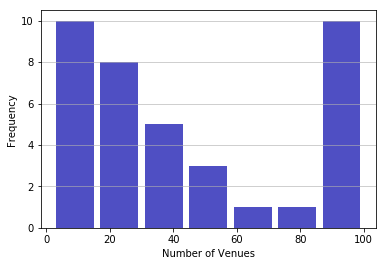

In [135]:
import matplotlib.pyplot as plt
plt.hist(x=df['Venue'], bins='auto', color='#0504aa', alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Number of Venues')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

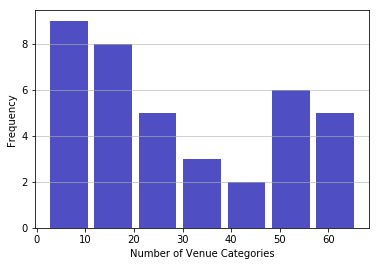

In [136]:
plt.hist(x=df['Venue Category'], bins='auto', color='#0504aa', alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Number of Venue Categories')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

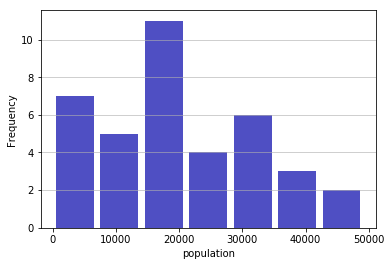

In [137]:
plt.hist(x=df['population'], bins='auto', color='#0504aa', alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('population')
plt.ylabel('Frequency')

Text(0, 0.5, 'Venue Category')

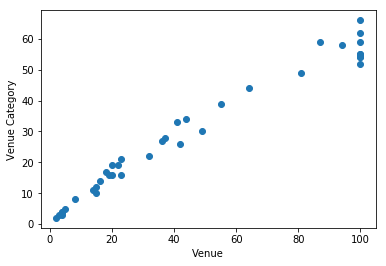

In [141]:
plt.scatter(x = df['Venue'], y = df['Venue Category'])
plt.xlabel('Venue')
plt.ylabel('Venue Category')

Text(0, 0.5, 'population')

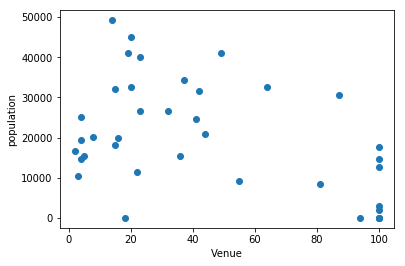

In [142]:
plt.scatter(x = df['Venue'], y = df['population'])
plt.xlabel('Venue')
plt.ylabel('population')

Text(0, 0.5, 'population')

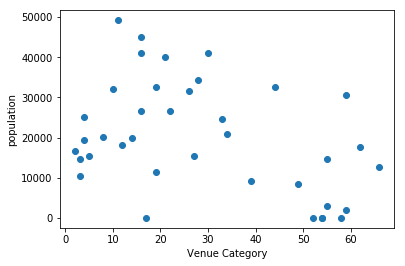

In [143]:
plt.scatter(x = df['Venue Category'], y = df['population'])
plt.xlabel('Venue Category')
plt.ylabel('population')

Coefficients: 
 [-274.9533044]
Mean squared error: 153657504.79
Variance score: 0.17


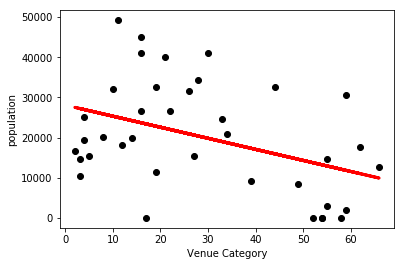

In [161]:
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
regr = linear_model.LinearRegression()


regr.fit(df[['Venue Category']], df['population'])
y_pred = regr.predict(df[['Venue Category']])

print('Coefficients: \n', regr.coef_)
# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(df['population'], y_pred))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(df['population'], y_pred))

# Plot outputs
plt.scatter(df[['Venue Category']], df['population'],  color='black')
plt.plot(df[['Venue Category']], y_pred, color='red', linewidth=3)

plt.xlabel('Venue Category')
plt.ylabel('population')

plt.show()
